In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline


In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains, udf\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'take_500K.csv'
# Load the main data set into pyspark data frame 
df = spark.read.options(delimiter=",", header=True).csv(filename_data)
# df = spark.read.csv(filename_data)
# df = pd.read_csv(filename_data)
# print(df)
# df.drop(col('permalink'))



In [3]:
df = df.drop('_c0')
df = df.withColumn('sentiment', df['sentiment'].cast('float'))
df = df.withColumn('score', df['score'].cast('int'))
df = df.na.drop()

df.show()

+--------------------+-----------+--------------------+---------+-----+
|             subName|created_utc|                body|sentiment|score|
+--------------------+-----------+--------------------+---------+-----+
|                nova| 2021-10-25|When you schedule...|      0.0|    2|
|             ontario| 2021-10-25|Compare BC to Ont...|      0.0|   -2|
|         antivaxxers| 2021-10-25|I don’t know anyo...|  -0.9191|    1|
|          conspiracy| 2021-10-25|BS. Not a fear ca...|  -0.9625|    1|
|      torontoraptors| 2021-10-25|Idk if they have ...|  -0.0516|    3|
|personalfinanceca...| 2021-10-25|I got some crappy...|   0.6604|    2|
|             economy| 2021-10-25|Pretty sure the e...|   0.6705|    1|
|         redscarepod| 2021-10-25|Lol it’s kinda fu...|   0.4417|    6|
|               korea| 2021-10-25|It's racist in th...|  -0.8481|    9|
|             alberta| 2021-10-25|When it comes to ...|   0.4215|    0|
|       beyondthebump| 2021-10-25|Any other kids I ...|   0.6331

In [4]:
from pyspark.ml.feature import VectorAssembler

# Создание вектора признаков
feature_assembler  = VectorAssembler(inputCols=['sentiment', 'score'], outputCol='features')
X = feature_assembler.transform(df)
y = X.select("score")

In [5]:
# Разделение данных на тренировочный и тестовый наборы
train_data, test_data = X.randomSplit([0.7, 0.3], seed=42)
train_y, test_y = y.randomSplit([0.7, 0.3], seed=42)

In [6]:
train_data.count()

347116

In [7]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Создание и обучение модели линейной регрессии
lr = LinearRegression(featuresCol="features", labelCol="score", maxIter=10, regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[feature_assembler, lr])
model = lr.fit(train_data)

print("Coefficients: %s" % model.coefficients)
print("Intercept: %s" % model.intercept)

Coefficients: [0.0,0.8943585784221677]
Intercept: 0.26573694886042504


In [8]:
predictions = model.transform(test_data)
predictions.show()

+------------+-----------+--------------------+---------+-----+--------------------+------------------+
|     subName|created_utc|                body|sentiment|score|            features|        prediction|
+------------+-----------+--------------------+---------+-----+--------------------+------------------+
|         196| 2021-10-23|Same, discovered ...|   0.4215|    8|[0.42149999737739...| 7.420605576237767|
|         196| 2021-10-24|It's about giving...|     0.34|    2|[0.34000000357627...|2.0544541057047603|
|         196| 2021-10-25|True but I'd rath...|  -0.1442|    9|[-0.1441999971866...| 8.314964154659934|
|   2007scape| 2021-10-23|It's been like 20...|   0.4215|    1|[0.42149999737739...|1.1600955272825928|
|     23andme| 2021-10-23|That’s true, but ...|  -0.6297|    3|[-0.6297000050544...| 2.948812684126928|
|     2asia4u| 2021-10-23|I got COVID a few...|   0.9578|    3|[0.95779997110366...| 2.948812684126928|
|     2asia4u| 2021-10-25|Can barely see th...|  -0.4404|    6|[

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator
for metric in ["mse", "rmse", "mae", "var", "r2"]:
    regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="score", metricName=metric)
    calculated_metric = regression_evaluator.evaluate(predictions)
    print(f"{metric}: {calculated_metric}") # метрики

mse: 0.0861446061957255
rmse: 0.2935040139346061
mae: 0.2193096886306756
var: 6.1742322603946
r2: 0.988839889841385


Random Forest

In [10]:
df = spark.read.options(delimiter=",", header=True).csv(filename_data)
df = df.drop('_c0')
df = df.withColumn('sentiment', df['sentiment'].cast('float'))
df = df.withColumn('score', df['score'].cast('int'))
df = df.na.drop()

df.show()

+--------------------+-----------+--------------------+---------+-----+
|             subName|created_utc|                body|sentiment|score|
+--------------------+-----------+--------------------+---------+-----+
|                nova| 2021-10-25|When you schedule...|      0.0|    2|
|             ontario| 2021-10-25|Compare BC to Ont...|      0.0|   -2|
|         antivaxxers| 2021-10-25|I don’t know anyo...|  -0.9191|    1|
|          conspiracy| 2021-10-25|BS. Not a fear ca...|  -0.9625|    1|
|      torontoraptors| 2021-10-25|Idk if they have ...|  -0.0516|    3|
|personalfinanceca...| 2021-10-25|I got some crappy...|   0.6604|    2|
|             economy| 2021-10-25|Pretty sure the e...|   0.6705|    1|
|         redscarepod| 2021-10-25|Lol it’s kinda fu...|   0.4417|    6|
|               korea| 2021-10-25|It's racist in th...|  -0.8481|    9|
|             alberta| 2021-10-25|When it comes to ...|   0.4215|    0|
|       beyondthebump| 2021-10-25|Any other kids I ...|   0.6331

In [11]:
# Define the categorical feature (hashtags)
categoricalCols = ["sentiment"]

# Define the numerical features
numericalCols = ["score"]

In [12]:
from pyspark.sql.functions import when
df = df.withColumn('sentiment', when(df['sentiment'] > 0.1, lit(1)).otherwise(lit(0)))
df.show()

+--------------------+-----------+--------------------+---------+-----+
|             subName|created_utc|                body|sentiment|score|
+--------------------+-----------+--------------------+---------+-----+
|                nova| 2021-10-25|When you schedule...|        0|    2|
|             ontario| 2021-10-25|Compare BC to Ont...|        0|   -2|
|         antivaxxers| 2021-10-25|I don’t know anyo...|        0|    1|
|          conspiracy| 2021-10-25|BS. Not a fear ca...|        0|    1|
|      torontoraptors| 2021-10-25|Idk if they have ...|        0|    3|
|personalfinanceca...| 2021-10-25|I got some crappy...|        1|    2|
|             economy| 2021-10-25|Pretty sure the e...|        1|    1|
|         redscarepod| 2021-10-25|Lol it’s kinda fu...|        1|    6|
|               korea| 2021-10-25|It's racist in th...|        0|    9|
|             alberta| 2021-10-25|When it comes to ...|        1|    0|
|       beyondthebump| 2021-10-25|Any other kids I ...|        1

In [13]:
from pyspark.ml.feature import StringIndexer

# Convert the categorical feature into a numerical feature using string indexing
indexer = StringIndexer(inputCols=categoricalCols, outputCols=[c + "Index" for c in categoricalCols])
indexed = indexer.fit(df).transform(df)

In [14]:
# Combine the numerical and numerical features into a single vector column
assembler = VectorAssembler(inputCols=numericalCols, outputCol="features")
output = assembler.transform(indexed)

In [15]:
# Split the data into training and test sets (70%/30%)
train, test = output.randomSplit([0.7, 0.3])

In [16]:
major_df = train.filter(col("sentiment") == 0)
minor_df = train.filter(col("sentiment") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 1


In [17]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import array

sampled_majority_df = major_df.sample(False, 1/ratio)
train = sampled_majority_df.unionAll(minor_df)

a = range(ratio)

oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')# combine both oversampled minority rows and previous majority rows 
train = major_df.unionAll(oversampled_df)
train.show()

+--------------------+-----------+--------------------+---------+-----+--------------+--------+
|             subName|created_utc|                body|sentiment|score|sentimentIndex|features|
+--------------------+-----------+--------------------+---------+-----+--------------+--------+
|                 196| 2021-10-23|Look at what the ...|        0|    6|           0.0|   [6.0]|
|                 196| 2021-10-24|Fr tho, if I reme...|        0|    5|           0.0|   [5.0]|
|                 196| 2021-10-25|True but I'd rath...|        0|    9|           0.0|   [9.0]|
|           2007scape| 2021-10-24|Why March 2021? O...|        0|    2|           0.0|   [2.0]|
|             23andme| 2021-10-23|That’s true, but ...|        0|    3|           0.0|   [3.0]|
|        2meirl4meirl| 2021-10-24|Ahh back when we ...|        0|    4|           0.0|   [4.0]|
|        2meirl4meirl| 2021-10-24|Broooo... im lite...|        0|    1|           0.0|   [1.0]|
|     2middleeast4you| 2021-10-23|Pre co

In [18]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="sentiment", featuresCol="features", numTrees=100)

In [19]:
# Train the model on the training data
model = rf.fit(train)

In [20]:
# Make predictions on the test data
predictions = model.transform(test) 


In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate the model using binary classification metrics
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="sentiment")
auc = evaluator.evaluate(predictions)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="sentiment", metricName="areaUnderPR")
apr = evaluator.evaluate(predictions)
print("Area Under ROC (test) =", auc)

rfSummary = model.summary
print("Area under ROC (train): ", rfSummary.areaUnderROC)

Area Under ROC (test) = 0.5
Area under ROC (train):  0.5


In [22]:
predictions.select(['sentiment','score']).toPandas()

,sentiment,score
0,0,6
1,0,2
2,0,2
3,0,6
4,0,4
...,...,...
148625,0,4
148626,0,1
148627,1,3
148628,0,4


In [23]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'ROC')

Text(0.5, 0, 'True Positive Rate')

Text(0, 0.5, 'False Positive Rate')

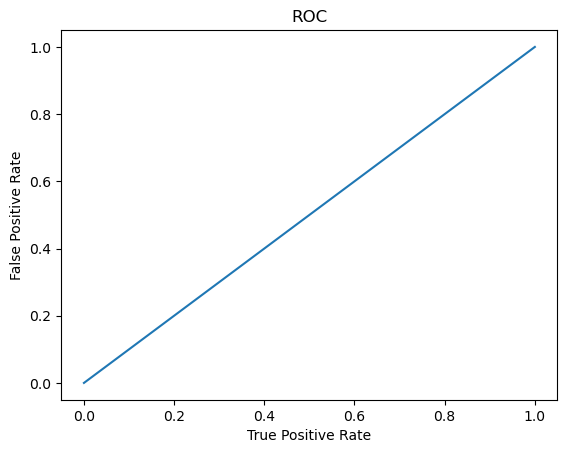

In [25]:
# Create a Pipeline estimator and fit on train DF, predict on test DF
# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('score','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['score'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.plot(x_val, y_val)